# Final Project - Reinforcements Learning 
Hello dear students,<br> this is the template notebook. Please click on the "File" tab and then on "Save a copy into drive".

---
<br>

### Name and ID:
Student 1: Avraham Raviv, 204355390
<br>
Student 2: Yevgeni Berkovitch, 317079234
<br><br>
<img src="https://play-lh.googleusercontent.com/e_oKlKPISbgdzut1H9opevS7-LTB8-8lsmpCdMkhlnqFenZhpjxbLmx7l158-xQQCIY">

### https://github.com/mpSchrader/gym-sokoban

# Installs

In [1]:
%%capture
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install 'imageio==2.4.0'
!pip install gym
!pip install pygame
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet
!pip install gym
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install gym_sokoban

!imageio_download_bin ffmpeg

# Imports

In [2]:
import random

import numpy as np
import matplotlib.pyplot as plt

import base64
import imageio
from pyvirtualdisplay import Display
from IPython.display import HTML

import gym
from gym import error, spaces, utils
from soko_pap import *

from collections import deque

from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten

import tensorflow
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

from tqdm.notebook import tqdm
from collections import defaultdict

In [3]:
%matplotlib inline

In [4]:
imageio.plugins.ffmpeg.download()

In [5]:
from gym import logger as gymlogger
gymlogger.set_level(40) # error only

In [6]:
import warnings
warnings.filterwarnings('ignore')

# Display utils
The cell below contains the video display configuration. No need to make changes here.

In [7]:
def embed_mp4(filename):
    """Embeds an mp4 file in the notebook."""
    video = open(filename,'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>'''.format(b64.decode())

    return HTML(tag)

# Utils

In [8]:
def get_distances_for_target(room_state, target):
    distances = np.zeros(shape=room_state.shape)
    visited_cells = set()
    cell_queue = deque()

    visited_cells.add(target)
    cell_queue.appendleft(target)

    while len(cell_queue) != 0:
        cell = cell_queue.pop()
        distance = distances[cell[0]][cell[1]]
        for x,y in ((1,0), (-1,-0), (0,1), (0,-1)):
            next_cell_x, next_cell_y = cell[0]+x, cell[1]+y
            if room_state[next_cell_x][next_cell_y] != 0 and not (next_cell_x, next_cell_y) in visited_cells:
                distances[next_cell_x][next_cell_y] = distance + 1
                visited_cells.add((next_cell_x, next_cell_y))
                cell_queue.appendleft((next_cell_x, next_cell_y))
                
    return distances

def get_maze_info(room_state):
    targets = []
    for i in range(room_state.shape[0]):
        for j in range(room_state.shape[1]):
            if room_state[i][j] == 2:
                targets.append((i, j))

    distances0 = get_distances_for_target(room_state, targets[0])
    distances1 = get_distances_for_target(room_state, targets[1])
    common_distances = np.minimum(distances0, distances1)
    
    maze_info = {}
    maze_info['target0'] = targets[0]
    maze_info['target1'] = targets[1]
    maze_info['distances0'] = distances0
    maze_info['distances1'] = distances1
    maze_info['coomon_distances'] = common_distances
    return maze_info

def calc_distances(room_state, distances):
    boxes = []
    for i in range(room_state.shape[0]):
        for j in range(room_state.shape[1]):            
            if room_state[i][j] == 4:
                boxes.append((i,j))
    if len(boxes) == 2:
        return distances[boxes[0][0]][boxes[0][1]] + distances[boxes[1][0]][boxes[1][1]]
    
    return distances[boxes[0][0]][boxes[0][1]]

def box2target_change_reward(room_state, next_room_state, maze_info):    
    target0 = maze_info['target0']
    target1 = maze_info['target1']
    distances0 = maze_info['distances0']
    distances1 = maze_info['distances1']
    common_distances = maze_info['coomon_distances']
    
    relevant_distances = common_distances    
    
    if room_state[target0[0]][target0[1]] == 3:
        relevant_distances = distances1
    elif room_state[target1[0]][target1[1]] == 3:
        relevant_distances = distances0
    
    change_reward = 0.0      
    t2b = calc_distances(room_state, relevant_distances)
    n_t2b = calc_distances(next_room_state, relevant_distances)
    if n_t2b < t2b:
        change_reward += 5.0
    elif n_t2b > t2b:
        change_reward -= 5.0
        
    return change_reward  

# Solution

In [9]:
class SOK_Agent:
    def __init__(self):
        # Construct DQN models
        self.state_size = (112,112,1) 
        self.action_size = 8
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.target_model.set_weights(self.model.get_weights())
        self.batch_size = 8
        
        # Replay buffers
        self.replay_buffer = deque(maxlen=50000)
        self.prioritized_replay_buffer = deque(maxlen=50000)
        
        # Hyperparameters
        self.gamma = 0.9
        self.epsilon = 1.0   
        self.epsilon_min = 0.3
        self.epsilon_decay = 0.995
        self.replay_rate = 10
        self.update_beta = 0.999
        
        self.action_rotation_map = {
            0: 2,
            1: 3,
            2: 1,
            3: 0,
            4: 6,
            5: 7,
            6: 5,
            7: 4
        }

    def _build_model(self):
        model = Sequential()
        model.add(Conv2D(32, (16,16), strides=(16,16), input_shape=self.state_size, activation='relu'))
        model.add(Conv2D(64, (3,3), activation='relu'))
        model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
        model.add(Flatten())
        model.add(Dense(512, activation='relu'))    
        model.add(Dense(64, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        
        lr_schedule = ExponentialDecay(0.001, decay_steps=2000, decay_rate=0.99, staircase=False)
        model.compile(optimizer=Adam(learning_rate=lr_schedule), loss='mse')        
        return model

    def remember(self, state, action, reward, next_state, done):
        self.replay_buffer.append([state, action, reward, next_state, done])    
        
    def copy_to_prioritized_buffer(self, n):
        for i in range(n):
            self.prioritized_replay_buffer.append(self.replay_buffer[-1-i])  

    def act(self, state, stochastic=False):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        
        act_values = self.model.predict(state, verbose=0)[0]
        
        if stochastic:
            act_probs = np.exp(act_values)/np.exp(act_values).sum()
            return np.random.choice(np.arange(self.action_size), size=1, p=act_probs)[0]
              
        return np.argmax(act_values) 

    def replay(self): 
        if len(self.replay_buffer) < self.batch_size:
            return
        
        if len(self.prioritized_replay_buffer) < self.batch_size//2:
            minibatch = random.sample(self.replay_buffer, self.batch_size) 
        else:    
            minibatch = random.sample(self.replay_buffer, self.batch_size//2) 
            minibatch.extend(random.sample(self.prioritized_replay_buffer, self.batch_size//2))
        
        states = np.zeros((self.batch_size*4, self.state_size[0], self.state_size[1]))
        actions = np.zeros(self.batch_size*4, dtype=int)
        rewards = np.zeros(self.batch_size*4)
        next_states = np.zeros((self.batch_size*4, self.state_size[0], self.state_size[1]))
        statuses = np.zeros(self.batch_size*4)
        targets = np.zeros((self.batch_size*4, self.action_size)) 
        
        for i, (state, action, reward, next_state, done) in enumerate(minibatch): 
            for rot in range(4):  
                ind = i*4+rot
                if rot != 0:
                    state = np.rot90(state, axes=(1,2))
                    next_state = np.rot90(next_state, axes=(1,2))
                    action = self.action_rotation_map.get(action)

                states[ind] = state.copy()
                actions[ind] = action
                rewards[ind] = reward
                next_states[ind] = next_state.copy()
                statuses[ind] = 1 if done else 0          
        
        targets = self.model.predict(states) 
        max_actions = np.argmax(self.model.predict(next_states), axis=1)
        next_rewards = self.target_model.predict(next_states)
        
        ind = 0
        for action, reward, next_reward, max_action, done in zip(actions, rewards, next_rewards, max_actions, statuses):  
            if not done:
                reward += self.gamma * next_reward[max_action]
            targets[ind][action] = reward
            ind += 1
        
        self.model.fit(states, targets, epochs=10, verbose=0) 
        
        self.update_target_model()        
    
        if self.epsilon > self.epsilon_min:
            self.epsilon = self.epsilon * self.epsilon_decay    
        
    def update_target_model(self):
        model_w = self.model.get_weights()
        target_model_w = self.target_model.get_weights()
        updated_target_model_w = []
        for i in range(len(model_w)):
            updated_target_model_w.append(self.update_beta*target_model_w[i] + (1-self.update_beta)*model_w[i])
        self.target_model.set_weights(updated_target_model_w)    
            
    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

In [10]:
def process_frame(frame):
    f = frame.mean(axis=2)
    f = f / 255
    return np.expand_dims(f, axis=0)

## Training

#### Test Suite

In [11]:
max_episodes = 50000
max_steps = 40

def init_sok(r):
    random.seed(r)
    sok = PushAndPullSokobanEnv(dim_room=(7, 7), num_boxes=2)
    sok.set_maxsteps(max_steps)
    return sok

In [12]:
def test_agent(e, cur_record, stochastic=False):
    current_epsilon = agent.epsilon
    agent.epsilon = 0.0
    num_solved = 0

    for t in tqdm(range(100)):    
        sok = init_sok(t)
        steps = 0

        state = sok.get_image('rgb_array')
        done = False
        while not done:
            steps += 1
            action = agent.act(process_frame(state), stochastic)
            if action < 4:
                action += 1
            else:
                action += 5
            state, reward, done, info = sok.step(action)

        if sok.boxes_on_target == 2:            
            num_solved += 1
            
    agent.epsilon = current_epsilon    
    print("Episode %d Epsilon %.3f Learning Rate %.6f Solved: %d" % (
        e+1, 
        agent.epsilon, 
        agent.model.optimizer._decayed_lr(tensorflow.float32).numpy(),
        num_solved))
    
    if num_solved > cur_record:
        agent.save("models\Q3_04A_%d.h5" % (num_solved)) 
        cur_record = num_solved
        
    return num_solved, cur_record 

In [13]:
agent = SOK_Agent()
agent.load('models\Q3_04A_23.h5')
agent.epsilon = 0.3

running_puzzles = 0
running_solved = 0
solved_in_train = []
solved_in_test = []
test_record = 0

for e in range(max_episodes):
    sok = init_sok(e+100)
    random.seed(e)
    running_puzzles += 1
    
    state = process_frame(sok.get_image('rgb_array'))
    room_state = sok.room_state.copy() 
    maze_info = get_maze_info(room_state)
    
    for step in range(sok.max_steps):
        action = agent.act(state)
        if action < 4:
            next_state, reward, done, _ = sok.step(action+1) 
        else:
            next_state, reward, done, _ = sok.step(action+5)         
        
        next_state = process_frame(next_state)        
        next_room_state = sok.room_state
        
        if reward <= -1.0:
            reward = -10.0
        elif reward >= 1.0:
            reward = 10.0
        elif not done:
            reward += box2target_change_reward(room_state, next_room_state, maze_info)
        
        agent.remember(state, action, reward, next_state, done)
        
        state = next_state.copy() 
        room_state = next_room_state.copy()                
        
        if (step+1) % agent.replay_rate == 0:
            agent.replay()            
        
        if done: 
            if sok.boxes_on_target == 2:  
                agent.copy_to_prioritized_buffer(step+1)  
                running_solved += 1
                
            if (e+1) % 10 == 0 and e > 0:
                print(f"{running_solved} | {running_puzzles}") 

                if (e+1) % 100 == 0:
                    solved_in_train.append(running_solved)
                    running_puzzles = 0
                    running_solved = 0
                    
            break
            
    if (e+1) % 100 == 0 and e > 0:
        solved_tests, test_record = test_agent(e, test_record, stochastic=False) 
        solved_in_test.append(solved_tests)

3 | 10
6 | 20
9 | 30
9 | 40
9 | 50
10 | 60
11 | 70
13 | 80
17 | 90
19 | 100


[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .

Episode 100 Epsilon 0.300 Learning Rate 0.000983 Solved: 4
1 | 10
2 | 20
2 | 30
3 | 40
6 | 50
9 | 60
9 | 70
9 | 80
11 | 90
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
12 | 100


[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .

Episode 200 Epsilon 0.300 Learning Rate 0.000965 Solved: 2
1 | 10
3 | 20
6 | 30
8 | 40
11 | 50
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
12 | 60
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
13 | 70
14 | 80
14 | 90
14 | 100


[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .

Episode 300 Epsilon 0.300 Learning Rate 0.000948 Solved: 3
4 | 10
5 | 20
6 | 30
8 | 40
10 | 50
12 | 60
13 | 70
15 | 80
16 | 90
18 | 100


[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .

Episode 400 Epsilon 0.300 Learning Rate 0.000932 Solved: 7
1 | 10
4 | 20
5 | 30
5 | 40
7 | 50
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
9 | 60
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
11 | 70
12 | 80
13 | 90
17 | 100


[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .

Episode 500 Epsilon 0.300 Learning Rate 0.000915 Solved: 9
3 | 10
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
5 | 20
7 | 30
9 | 40
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
10 | 50
12 | 60
16 | 70
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
16 | 80
18 | 90
20 | 100


[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .

Episode 600 Epsilon 0.300 Learning Rate 0.000900 Solved: 17
3 | 10
4 | 20
5 | 30
8 | 40
11 | 50
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
14 | 60
17 | 70
19 | 80
20 | 90
22 | 100


[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .

Episode 700 Epsilon 0.300 Learning Rate 0.000886 Solved: 23
3 | 10
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
3 | 20
6 | 30
8 | 40
12 | 50
16 | 60
21 | 70
25 | 80
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
29 | 90
32 | 100


[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .

Episode 800 Epsilon 0.300 Learning Rate 0.000873 Solved: 22
3 | 10
3 | 20
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
6 | 30
9 | 40
10 | 50
16 | 60
16 | 70
19 | 80
23 | 90
25 | 100


[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .

Episode 900 Epsilon 0.300 Learning Rate 0.000860 Solved: 21
1 | 10
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
5 | 20
7 | 30
7 | 40
8 | 50
9 | 60
12 | 70
14 | 80
18 | 90
23 | 100


[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .

Episode 1000 Epsilon 0.300 Learning Rate 0.000846 Solved: 13
1 | 10
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
3 | 20
6 | 30
8 | 40
12 | 50
15 | 60
16 | 70
20 | 80
23 | 90
26 | 100


[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .

Episode 1100 Epsilon 0.300 Learning Rate 0.000833 Solved: 21
2 | 10
6 | 20
7 | 30
9 | 40
12 | 50
14 | 60
17 | 70
21 | 80
24 | 90
28 | 100


[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .

Episode 1200 Epsilon 0.300 Learning Rate 0.000820 Solved: 23
0 | 10
3 | 20
5 | 30
7 | 40
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
7 | 50
10 | 60
11 | 70
14 | 80
16 | 90
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
18 | 100


[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .

Episode 1300 Epsilon 0.300 Learning Rate 0.000806 Solved: 20
2 | 10
3 | 20
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
6 | 30
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
12 | 40
17 | 50
18 | 60
19 | 70
21 | 80
23 | 90
26 | 100


[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .

Episode 1400 Epsilon 0.300 Learning Rate 0.000794 Solved: 22
4 | 10
7 | 20
12 | 30
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
14 | 40
18 | 50
20 | 60
20 | 70
23 | 80
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
26 | 90
29 | 100


[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .

Episode 1500 Epsilon 0.300 Learning Rate 0.000782 Solved: 19
4 | 10
5 | 20
8 | 30
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
11 | 40
13 | 50
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
17 | 60
21 | 70
23 | 80
24 | 90
26 | 100


[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .

Episode 1600 Epsilon 0.300 Learning Rate 0.000769 Solved: 18
6 | 10
8 | 20
12 | 30
17 | 40
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
19 | 50
20 | 60
24 | 70
26 | 80
28 | 90
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
31 | 100


[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .

Episode 1700 Epsilon 0.300 Learning Rate 0.000758 Solved: 24
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
1 | 10
4 | 20
6 | 30
9 | 40
12 | 50
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
14 | 60
17 | 70
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
18 | 80
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
19 | 90
21 | 100


[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .

Episode 1800 Epsilon 0.300 Learning Rate 0.000745 Solved: 11
3 | 10
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
7 | 20
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
9 | 30
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
15 | 40
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
17 | 50
21 | 60
25 | 70
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
29 | 80
31 | 90
36 | 100


[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .

Episode 1900 Epsilon 0.300 Learning Rate 0.000734 Solved: 23
3 | 10
6 | 20
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
9 | 30
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
14 | 40
19 | 50
21 | 60
24 | 70
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
26 | 80
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
29 | 90
32 | 100


[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .

Episode 2000 Epsilon 0.300 Learning Rate 0.000723 Solved: 22
3 | 10
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
3 | 20
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
6 | 30
8 | 40
13 | 50
17 | 60
21 | 70
25 | 80
27 | 90
30 | 100


[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .

Episode 2100 Epsilon 0.300 Learning Rate 0.000712 Solved: 25
3 | 10
5 | 20
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
7 | 30
11 | 40
16 | 50
18 | 60
19 | 70
22 | 80
24 | 90
25 | 100


[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .

Episode 2200 Epsilon 0.300 Learning Rate 0.000701 Solved: 16
1 | 10
4 | 20
6 | 30
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
8 | 40
11 | 50
15 | 60
18 | 70
22 | 80
26 | 90
28 | 100


[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .

Episode 2300 Epsilon 0.300 Learning Rate 0.000690 Solved: 20
1 | 10
3 | 20
5 | 30
10 | 40
13 | 50
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
16 | 60
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
20 | 70
21 | 80
25 | 90
28 | 100


[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .

Episode 2400 Epsilon 0.300 Learning Rate 0.000679 Solved: 29
3 | 10
6 | 20
9 | 30
13 | 40
15 | 50
16 | 60
16 | 70
22 | 80
27 | 90
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
33 | 100


[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .

Episode 2500 Epsilon 0.300 Learning Rate 0.000669 Solved: 30
4 | 10
8 | 20
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
13 | 30
15 | 40
17 | 50
21 | 60
23 | 70
27 | 80
29 | 90
32 | 100


[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .

Episode 2600 Epsilon 0.300 Learning Rate 0.000659 Solved: 12
5 | 10
7 | 20
11 | 30
13 | 40
15 | 50
18 | 60
20 | 70
23 | 80
26 | 90
29 | 100


[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .

Episode 2700 Epsilon 0.300 Learning Rate 0.000649 Solved: 24
3 | 10
5 | 20
8 | 30
12 | 40
14 | 50
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
19 | 60
26 | 70
29 | 80
30 | 90
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
35 | 100


[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .

Episode 2800 Epsilon 0.300 Learning Rate 0.000640 Solved: 18
2 | 10
5 | 20
7 | 30
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
10 | 40
13 | 50
16 | 60
18 | 70
24 | 80
28 | 90
32 | 100


[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .

Episode 2900 Epsilon 0.300 Learning Rate 0.000630 Solved: 26
1 | 10
5 | 20
9 | 30
10 | 40
13 | 50
18 | 60
24 | 70
27 | 80
29 | 90
32 | 100


[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .

Episode 3000 Epsilon 0.300 Learning Rate 0.000620 Solved: 19
6 | 10
10 | 20
14 | 30
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
19 | 40
22 | 50
26 | 60
28 | 70
31 | 80
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
34 | 90
37 | 100


[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .

Episode 3100 Epsilon 0.300 Learning Rate 0.000612 Solved: 25
2 | 10
7 | 20
11 | 30
14 | 40
17 | 50
21 | 60
24 | 70
28 | 80
32 | 90
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
35 | 100


[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .

Episode 3200 Epsilon 0.300 Learning Rate 0.000603 Solved: 12
1 | 10
2 | 20
4 | 30
6 | 40
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
11 | 50
13 | 60
16 | 70
19 | 80
21 | 90
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
23 | 100


[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .

Episode 3300 Epsilon 0.300 Learning Rate 0.000593 Solved: 14
2 | 10


KeyboardInterrupt: 

In [ ]:
# check what agent solves
# check rewards

In [16]:
agent.epsilon = 0.0

for t in range(100):    
    sok = init_sok(t)
    steps = 0

    state = sok.get_image('rgb_array')
    done = False
    while not done:
        steps += 1
        action = agent.act(process_frame(state), stochastic=False)
        if action < 4:
            action += 1
        else:
            action += 5
        state, reward, done, info = sok.step(action)

    if sok.boxes_on_target == 2:            
        print("Solved %d Steps %d" % (t, steps))

Solved 0 Steps 11
Solved 4 Steps 4
Solved 6 Steps 4
Solved 7 Steps 4
Solved 11 Steps 3
Solved 14 Steps 3
Solved 20 Steps 4
Solved 22 Steps 9
Solved 25 Steps 3
Solved 35 Steps 4
Solved 37 Steps 4
Solved 41 Steps 8
Solved 43 Steps 8
Solved 48 Steps 9
Solved 52 Steps 6
Solved 53 Steps 4
Solved 54 Steps 3
Solved 57 Steps 3
Solved 58 Steps 4
Solved 66 Steps 3
Solved 68 Steps 3
Solved 74 Steps 5
Solved 76 Steps 10
Solved 82 Steps 3
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
Solved 89 Steps 6
Solved 93 Steps 11
Solved 95 Steps 6
Solved 96 Steps 6


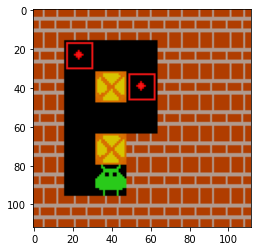

In [107]:
sok = init_sok(24)
screen = sok.get_image('rgb_array')
room_state = sok.room_state.copy() 
maze_info = get_maze_info(room_state)
plt.imshow(screen)

In [128]:
room_state = sok.room_state.copy()
next_state, reward, done, _ = sok.step(3)      
next_room_state = sok.room_state.copy()

if reward <= -1.0:
    reward = -10.0
elif reward >= 1.0:
    reward = 10.0
elif not done:
    reward += box2target_change_reward(room_state, next_room_state, maze_info)
    
print(room_state)
print("+++++++++++++++++++++++++")
print(next_room_state)
print("+++++++++++++++++++++++++")
print(reward)

[[0 0 0 0 0 0 0]
 [0 2 5 1 0 0 0]
 [0 1 4 2 0 0 0]
 [0 1 1 4 0 0 0]
 [0 1 1 0 0 0 0]
 [0 1 1 0 0 0 0]
 [0 0 0 0 0 0 0]]
+++++++++++++++++++++++++
[[0 0 0 0 0 0 0]
 [0 5 1 1 0 0 0]
 [0 1 4 2 0 0 0]
 [0 1 1 4 0 0 0]
 [0 1 1 0 0 0 0]
 [0 1 1 0 0 0 0]
 [0 0 0 0 0 0 0]]
+++++++++++++++++++++++++
-0.1


In [116]:
check.keys()

dict_keys([-0.1, -5.1, 4.9, 5.9, 10.0, -10.0, 0.1])